# Data Preparation

In [60]:
from matplotlib.colors import LinearSegmentedColormap
from datetime import datetime, timedelta
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import geopandas as gpd
import json
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

In [61]:
# Styling Cell
sns.set_theme(context="notebook", style="whitegrid")

SMALL_SIZE = 18
MEDIUM_SIZE = 24
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Historical Data Import

In [62]:
historical = pd.read_csv('./data/kern_historical.csv', low_memory=False)
historical['time'] = pd.to_datetime(historical['time'])
historical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3462168 entries, 0 to 3462167
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   field_id     object        
 1   crop         int64         
 2   time         datetime64[ns]
 3   actual_et    float64       
 4   actual_eto   float64       
 5   actual_etof  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 158.5+ MB


In [63]:
historical = historical.rename(columns={"actual_eto_x": 'actual_et', "actual_eto_y": 'actual_eto'})

## Forecast Table Build

In [64]:
# Gather current forecast data for the county
forecasting_table = pd.DataFrame()
files = Path(f"data/forecasts/fret/").glob("kern*.csv")

for file in files:
    parts = str(file.name).split("_")
    data = pd.read_csv(file, low_memory=False)
    data["forecasting_date"] = parts[2].split('.')[0]
    forecasting_table = pd.concat([data, forecasting_table], ignore_index=True)

forecasting_table['forecasting_date'] = pd.to_datetime(forecasting_table['forecasting_date'])
forecasting_table['time'] = pd.to_datetime(forecasting_table['time'])
forecasting_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26262 entries, 0 to 26261
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   field_id          26262 non-null  object        
 1   crop              26262 non-null  int64         
 2   time              26262 non-null  datetime64[ns]
 3   fret_et           22602 non-null  float64       
 4   fret_eto          22802 non-null  float64       
 5   fret_etof         26064 non-null  float64       
 6   forecasting_date  26262 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(3), int64(1), object(1)
memory usage: 1.4+ MB


## Main Table Merge

In [65]:
analysis_end_date = datetime(year=2024, month=9, day=21)

In [66]:
dt = historical.loc[(historical['time'].dt.year == 2024), :]
dt = dt.merge(forecasting_table, on=['field_id', 'time', 'crop'], how='right').set_index(['forecasting_date', 'field_id', 'crop', 'time']).reset_index()
dt = dt.dropna(subset=['fret_et', 'fret_eto', 'fret_etof'], how='any')
dt

,forecasting_date,field_id,crop,time,actual_et,actual_eto,actual_etof,fret_et,fret_eto,fret_etof
0,2024-09-25,CA_27267,61,2024-09-26,NaN,NaN,NaN,0.577,5.15,0.112
1,2024-09-25,CA_27267,61,2024-09-27,NaN,NaN,NaN,1.107,4.73,0.234
2,2024-09-25,CA_27267,61,2024-09-28,NaN,NaN,NaN,1.065,4.82,0.221
3,2024-09-25,CA_27267,61,2024-09-29,NaN,NaN,NaN,1.186,5.62,0.211
4,2024-09-25,CA_27267,61,2024-09-30,NaN,NaN,NaN,1.044,5.17,0.202
...,...,...,...,...,...,...,...,...,...,...
26256,2024-09-12,CA_423678,61,2024-09-15,0.049,6.003,0.008,0.045,5.02,0.009
26257,2024-09-12,CA_423678,61,2024-09-16,0.032,3.918,0.008,0.036,4.02,0.009
26258,2024-09-12,CA_423678,61,2024-09-17,0.033,4.002,0.008,0.040,3.99,0.010
26259,2024-09-12,CA_423678,61,2024-09-18,0.036,4.419,0.008,0.048,3.96,0.012


In [67]:
dt.head(100)

,forecasting_date,field_id,crop,time,actual_et,actual_eto,actual_etof,fret_et,fret_eto,fret_etof
0,2024-09-25,CA_27267,61,2024-09-26,NaN,NaN,NaN,0.577,5.15,0.112
1,2024-09-25,CA_27267,61,2024-09-27,NaN,NaN,NaN,1.107,4.73,0.234
2,2024-09-25,CA_27267,61,2024-09-28,NaN,NaN,NaN,1.065,4.82,0.221
3,2024-09-25,CA_27267,61,2024-09-29,NaN,NaN,NaN,1.186,5.62,0.211
4,2024-09-25,CA_27267,61,2024-09-30,NaN,NaN,NaN,1.044,5.17,0.202
...,...,...,...,...,...,...,...,...,...,...
108,2024-09-25,CA_298170,72,2024-09-30,NaN,NaN,NaN,2.605,4.99,0.522
109,2024-09-25,CA_298170,72,2024-10-01,NaN,NaN,NaN,2.601,5.05,0.515
110,2024-09-25,CA_298170,72,2024-10-02,NaN,NaN,NaN,2.524,4.93,0.512
112,2024-09-25,CA_298175,72,2024-09-26,NaN,NaN,NaN,2.330,4.49,0.519


## Unique Identifiers

In [68]:
forecast_dates = forecasting_table['forecasting_date'].unique()
fields = dt['field_id'].unique()
crops = dt['crop'].unique()

# Helpers
Below are functions that are being used to calculate data and generate plots.

The tables below are also calculated prior to speed up metric calculations.

### Average ET/ETo/ETof for 2024
This table will be used as a reference for any metric and plot calculations

In [69]:
avgs_table = dt.groupby(['field_id', 'crop'])[['actual_et', 'actual_eto', 'actual_etof']].agg('mean')
avgs_table.head()

,,actual_et,actual_eto,actual_etof
field_id,crop,,,
CA_27267,61,0.481000,4.364091,0.110909
CA_297922,75,2.959100,3.868000,0.765500
CA_297927,61,0.270636,3.789636,0.072091
CA_297932,204,1.052556,3.947889,0.265444
CA_297950,204,1.155200,4.089900,0.281700


### Climatology Reference
The table below records the average conditions for each field for each day of the year.

In [70]:
# Create a column for day of year
historical['doy'] = historical['time'].dt.dayofyear
# Group by field, crop, and doy then calculate the average conditions
climatology_table = historical.groupby(['field_id', 'crop', 'doy'])[['actual_et', 'actual_eto', 'actual_etof']].agg('mean')
climatology_table

actual_et  actual_eto  actual_etof
field_id  crop doy                                    
CA_27267  61   1     0.407556    1.045111     0.392111
               2     0.496444    1.198000     0.399111
               3     0.557667    1.385667     0.406000
               4     0.587000    1.432778     0.412778
               5     0.543000    1.291889     0.419889
...                       ...         ...          ...
CA_423678 61   362   0.264000    1.021375     0.270875
               363   0.278875    1.113250     0.271625
               364   0.298000    1.092750     0.268875
               365   0.207000    0.796625     0.265500
               366   0.161000    0.531000     0.306000

[397476 rows x 3 columns]

### calculate_metrics
This function calculate the mean absolute error (mae), root mean squared error (rmse), mean forecast error (bias), correlation coefficient (R), and skill score.

MAE, RMSE, and R are calculated using sklearn's metric module.

Skill score is calculated by getting the climatology for each field within the input's date range.
* Negative skill scores indicate the MSE for forecast is larger than the MSE for climatology
* Positive skill scores indicate otherwise

The function is very flexible given the data is formatted appropriately. It has the option of enabling normalization which is based on the average specified variable (ET, ETo, or ETof) throughout that field's historical data.

In [71]:
def calculate_metrics(data: pd.DataFrame, *, historical: pd.DataFrame, actual: str, expected: str, normalize: bool = False) -> pd.Series:
	# Calculate error metrics
    mae: float = mean_absolute_error(data[actual], data[expected])
    forecast_mse: float = mean_squared_error(data[actual], data[expected])
    rmse: float = np.sqrt(forecast_mse)

    # Correlation Coefficient (R)
    cor = data[actual].corr(data[expected]).astype(float)
    
    # Mean Forecast Bias determines if the forecast is overshooting or undershooting.
    # Greater positive number indicates overshooting.
    bias: float = np.mean(data[expected] - data[actual])

	# Climatology uses the mean actual variable for that time of year using historical data.
    field = data.head(1).squeeze()
    start_date = data['time'].min().dayofyear
    end_date = data['time'].max().dayofyear

	# Filter the climatology reference
    field_mask = (climatology_table.index.get_level_values(0) == field['field_id'])
    crop_mask = (climatology_table.index.get_level_values(1) == field['crop'])
    date_mask = ((climatology_table.index.get_level_values(2) >= start_date) & (climatology_table.index.get_level_values(2) <= end_date))
    
    climatology = climatology_table[field_mask & crop_mask & date_mask][actual]
    climatology_mse = mean_squared_error(data[actual], climatology)

	# Positive skill score indicates the error in climatology is greater than forecast.
    # This means that forecast is outperforming climatology.
    skill_score = 1 - np.max(np.min((forecast_mse / climatology_mse), initial=2), initial=-1)

    if normalize:
    	avg: float = avgs_table[avgs_table.index.get_level_values(0) == field['field_id']][actual].values[0]

    	mae: float = mae.astype(float) / avg.astype(float)
    	rmse = np.sqrt(forecast_mse.astype(float) / avg.astype(float))
    	bias = bias.astype(float) / avg.astype(float)

    return pd.Series({
    	'mae': mae.round(2),
    	'rmse': rmse.round(2),
    	'corr': cor.round(2),
    	'bias': bias.round(2),
    	'skill_score': skill_score.round(2)
	})

### eval_metrics
This function evaluates the metrics for each variable. The output is a DataFrame containing the metrics with a column specifying which variable (ET, ETo, ETof)

In [72]:
def eval_metrics(table: pd.DataFrame, by=['field_id', 'crop'], **kwargs) -> pd.DataFrame:
    metrics_table = pd.DataFrame(columns=["field_id", "variable", "crop", "mae", "rmse", "corr", "bias", "skill_score"])

    et_metrics = table.groupby(by=by)[["field_id", "crop", "time", "actual_et", "fret_et"]].apply(calculate_metrics, historical=historical,
                                                                      actual='actual_et', expected='fret_et', **kwargs).reset_index()
    et_metrics['variable'] = "ET"

    metrics_table = pd.concat([et_metrics.astype(metrics_table.dtypes), metrics_table.astype(et_metrics.dtypes)], ignore_index=True)

    eto_metrics = table.groupby(by=by)[["field_id", "crop", "time", "actual_eto", "fret_eto"]].apply(calculate_metrics, historical=historical,
                                                                      actual='actual_eto', expected='fret_eto', **kwargs).reset_index()
    eto_metrics['variable'] = "ETo"
    metrics_table = pd.concat([eto_metrics.astype(metrics_table.dtypes), metrics_table.astype(eto_metrics.dtypes)], ignore_index=True)

    etof_metrics = table.groupby(by=by)[["field_id", "crop", "time", "actual_etof", "fret_etof"]].apply(calculate_metrics, historical=historical,
                                                                      actual='actual_etof', expected='fret_etof', **kwargs).reset_index()
    etof_metrics['variable'] = "ETof"
    metrics_table = pd.concat([etof_metrics.astype(metrics_table.dtypes), metrics_table.astype(etof_metrics.dtypes)], ignore_index=True)

    return metrics_table

### timeseries_rel
This plot function utilizes the seaborn relplot method to create grids of plots. Particularly useful for showing distribution on one cell.

In [73]:
def timeseries_rel(data, *, y, plot='rel',
                   col=None, row=None, hue=None, kind='line', refline=None,
                   title='', ylabel='', as_percent=False, tighten=False,
                   errorbar=None, export_img: bool|str=None, title_template={}, **kwargs):
    match plot:
        case 'rel':
            rel = sns.relplot(data=data, x='forecasting_date', y=y, col=col, row=row, hue=hue, kind=kind, errorbar=errorbar, **kwargs)
        case 'dis': 
            rel = sns.displot(data=data, x=y, col=col, row=row, hue=hue, kind=kind, **kwargs)
        case 'cat':
            rel = sns.catplot(data=data, x='forecasting_date', y=y, col=col, row=row, hue=hue, kind=kind, errorbar=errorbar, **kwargs)
        case 'lm':
            rel = sns.lmplot(data=data, x='forecasting_date', y=y, col=col, row=row, hue=hue, kind=kind, errorbar=errorbar, **kwargs)
        case _:
            raise Exception('Not a valid plot type.')

    # Relabel y axis
    if ylabel: rel.set_ylabels(ylabel)
    # Relabel x axis
    rel.tick_params(axis='x', rotation=90)
    plt.suptitle(title, y=1.02);
    rel.set_titles(**title_template);

    if as_percent is True:
        for ax in rel.axes.flat:
            ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    if plot != 'dis':
        rel.set_xlabels('Forecasting Date')
        for ax in rel.axes.flat:
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))

    if tighten:
        rel.figure.subplots_adjust(wspace=0, hspace=0.1)

    if refline:
        rel.refline(**refline)

    if type(export_img) is bool and export_img is True: 
        rel.savefig(fname=f'images/monterey/{str(title)}')
    elif type(export_img) is str: 
        rel.savefig(fname=f'images/monterey/{export_img}')

    return rel

# Calculation

In [74]:
analysis_end_date = historical['time'].max()

Est. run time: 21m

In [75]:
metrics_norm = (dt[(dt['time'] > dt['forecasting_date']) & (dt['time'] < (dt['forecasting_date']) + timedelta(days=7)) & (dt['time'] < analysis_end_date)]
                .groupby(['forecasting_date'])[list(dt.columns)]
                .apply(eval_metrics, normalize=True))
metrics_norm.reset_index().to_csv('data/metrics/kern_fret_metrics_normalized.csv', index=False)

C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: in

In [76]:
metrics_norm = pd.read_csv('data/metrics/kern_fret_metrics_normalized.csv').drop(['level_1'], axis=1)
metrics_norm['forecasting_date'] = pd.to_datetime(metrics_norm['forecasting_date'])

In [77]:
metrics_norm.head()

,forecasting_date,field_id,crop,mae,rmse,corr,bias,skill_score,variable
0,2024-09-12,CA_27267,61,0.98,0.34,0.92,0.82,-1.00,ETof
1,2024-09-12,CA_297922,75,0.12,0.11,-0.87,-0.09,0.93,ETof
2,2024-09-12,CA_297927,61,0.13,0.07,0.91,-0.08,0.51,ETof
3,2024-09-12,CA_297932,204,0.58,0.32,-0.89,0.58,-0.05,ETof
4,2024-09-12,CA_297950,204,0.35,0.20,0.84,-0.32,-1.00,ETof


# Visualization

In [78]:
# First reshape data from wide-form to long-form
metrics_long = metrics_norm.reset_index().melt(id_vars=['forecasting_date', 'field_id', 'crop', 'variable'], value_vars=['mae', 'bias', 'skill_score'], var_name='stat')

In [79]:
# To help with visualization, map proper names to the stats
stat_propers = {
    'mae': 'Mean Absolute Error',
    'rmse': 'Root Mean Absolute Error',
    'bias': 'Mean Forecast Bias',
    'corr': 'Correlation Coefficient',
    'skill_score': 'Skill Score'
}
metrics_long['name'] = metrics_long['stat'].map(stat_propers)
metrics_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19548 entries, 0 to 19547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   forecasting_date  19548 non-null  datetime64[ns]
 1   field_id          19548 non-null  object        
 2   crop              19548 non-null  int64         
 3   variable          19548 non-null  object        
 4   stat              19548 non-null  object        
 5   value             19548 non-null  float64       
 6   name              19548 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 1.0+ MB


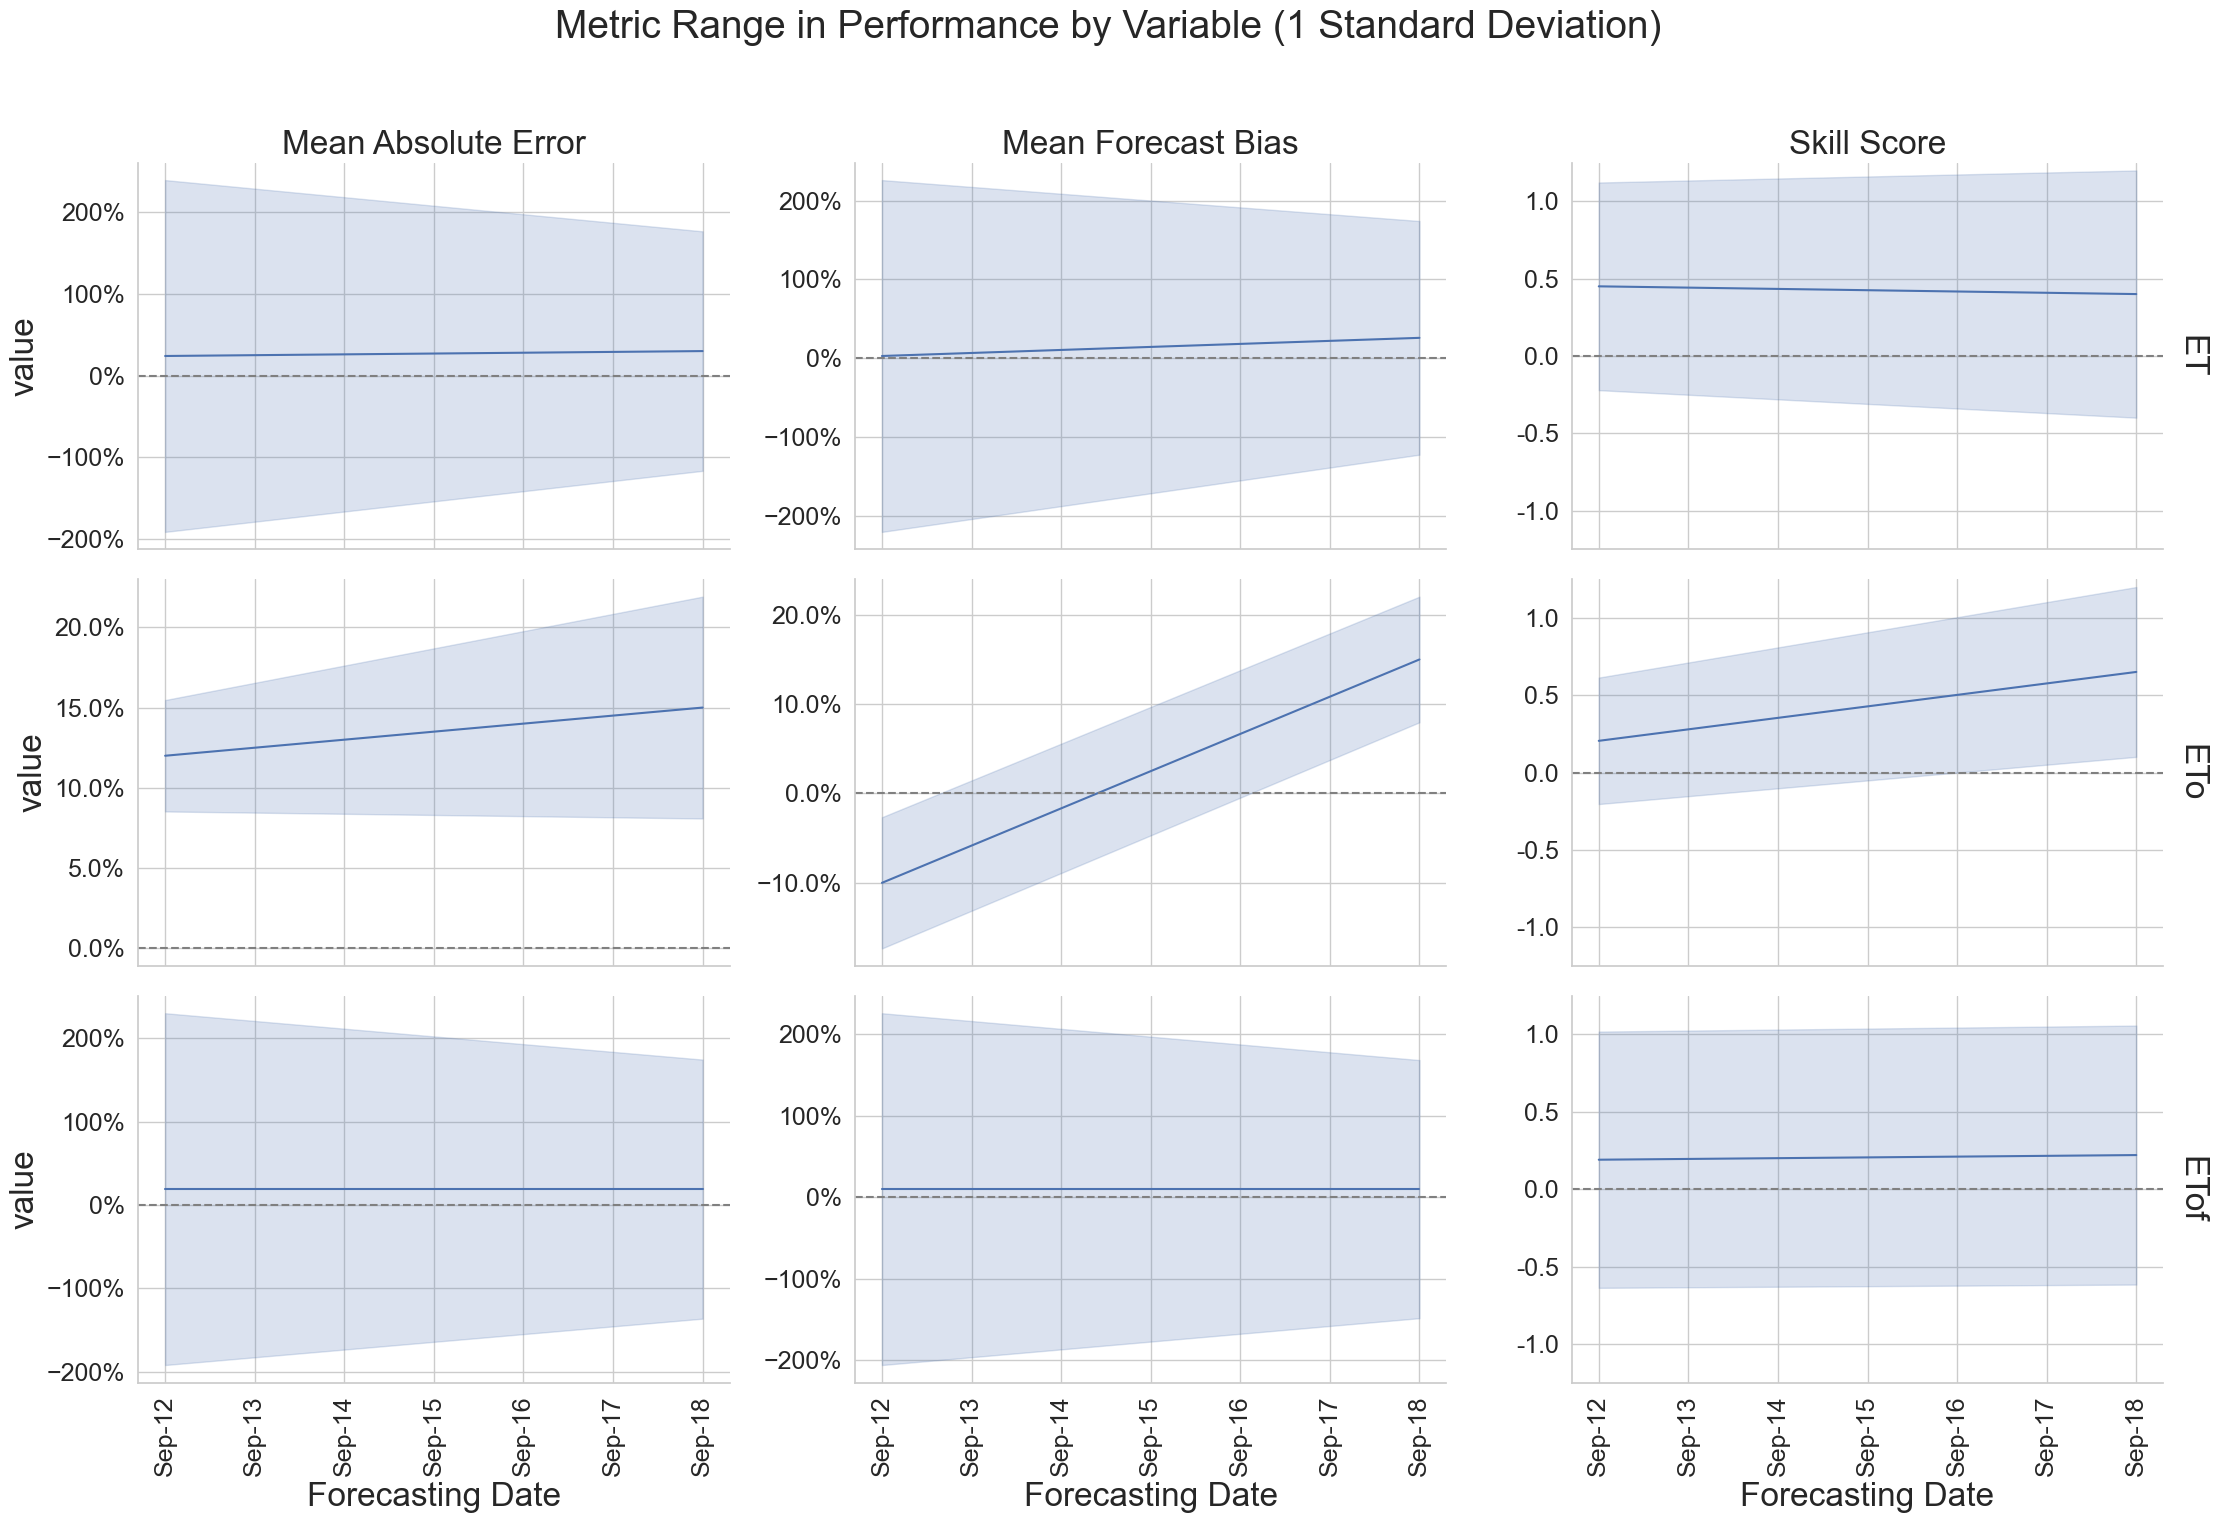

In [80]:
rel = timeseries_rel(metrics_long, row='variable', col='name', y='value',
                     errorbar='sd', estimator=np.median, as_percent=True,
                     refline={'y': 0},
                     facet_kws={'sharey': False, 'sharex': True, 'margin_titles': True}, aspect=1.5,
                     row_order=['ET', 'ETo', 'ETof'], title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                     title="Metric Range in Performance by Variable (1 Standard Deviation)");
rel.axes.flat[2].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[2].set(ylim=(-1.25, 1.25));
rel.axes.flat[2].set_yticks((1, 0.5, 0, -0.5, -1));
rel.axes.flat[5].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[5].set(ylim=(-1.25, 1.25));
rel.axes.flat[5].set_yticks((1, 0.5, 0, -0.5, -1));
rel.axes.flat[8].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[8].set(ylim=(-1.25, 1.25));
rel.axes.flat[8].set_yticks((1, 0.5, 0, -0.5, -1));